In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tour=pd.read_excel('/content/drive/MyDrive/datasets/Tourism.xlsx')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [ ]:
tour.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [ ]:
# First, let's look at the dimensions of the dataset using f-string which a new feature in Python, allowing you to modify strings by plugging in functions, methods etc. in curved brackets

print(f'There are {tour.shape[0]} rows and {tour.shape[1]} columns in the dataset')

#The output shows that it is not a very huge dataset.

There are 4888 rows and 20 columns in the dataset


In [ ]:
# I will drop CustomerID, because it is not a meaningful variable for the purposes of statistical analysis

tour.drop('CustomerID', axis=1, inplace=True)

**Converting data types:** Although each variable in the dataset includes numbers, some of those numbers in fact refer to categories, such as the variables ProdTaken and Passport. Therefore, I will need to change their data type to categorical.

Also, to ensure consistency among categorical variables and make analysis easier, I will change the data type of all objects to category.

In [ ]:
tour[['ProdTaken','TypeofContact','CityTier','Occupation','Gender','ProductPitched','MaritalStatus','Passport','OwnCar','Designation']]=tour[['ProdTaken','TypeofContact','CityTier','Occupation','Gender','ProductPitched','MaritalStatus','Passport','OwnCar','Designation']].astype('category')

In [ ]:
tour.info() #We can see the change we have made on the output below.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ProdTaken                 4888 non-null   category
 1   Age                       4662 non-null   float64 
 2   TypeofContact             4863 non-null   category
 3   CityTier                  4888 non-null   category
 4   DurationOfPitch           4637 non-null   float64 
 5   Occupation                4888 non-null   category
 6   Gender                    4888 non-null   category
 7   NumberOfPersonVisiting    4888 non-null   int64   
 8   NumberOfFollowups         4843 non-null   float64 
 9   ProductPitched            4888 non-null   category
 10  PreferredPropertyStar     4862 non-null   float64 
 11  MaritalStatus             4888 non-null   category
 12  NumberOfTrips             4748 non-null   float64 
 13  Passport                  4888 non-null   catego

In [ ]:
tour.describe().T #Let's provide a descriptive statistics of our numerical variables

,count,mean,std,min,25%,50%,75%,max
Age,4662.0,37.622265,9.316387,18.0,31.0,36.0,44.0,61.0
DurationOfPitch,4637.0,15.490835,8.519643,5.0,9.0,13.0,20.0,127.0
NumberOfPersonVisiting,4888.0,2.905074,0.724891,1.0,2.0,3.0,3.0,5.0
NumberOfFollowups,4843.0,3.708445,1.002509,1.0,3.0,4.0,4.0,6.0
PreferredPropertyStar,4862.0,3.581037,0.798009,3.0,3.0,3.0,4.0,5.0
NumberOfTrips,4748.0,3.236521,1.849019,1.0,2.0,3.0,4.0,22.0
PitchSatisfactionScore,4888.0,3.078151,1.365792,1.0,2.0,3.0,4.0,5.0
NumberOfChildrenVisiting,4822.0,1.187267,0.857861,0.0,1.0,1.0,2.0,3.0
MonthlyIncome,4655.0,23619.853491,5380.698361,1000.0,20346.0,22347.0,25571.0,98678.0


**Data Preprocessing:** On the dataset, some entries into the column gender were wrong in a way that Female had been written as Fe Male. I will solve the issue by writing a function that will correct the typo.

In [ ]:
def gender(gender_female):
    if isinstance(gender_female, str):  # checks if `income_val` is a string
        if gender_female=='Fe Male':
          return (gender_female.replace('Fe Male', 'Female'))
        elif gender_female=='Female':
          return (gender_female.replace('Female', 'Female'))
        elif gender_female=='Male':
          return (gender_female.replace('Male', 'Male'))
    else:
      return np.nan

In [ ]:
tour['Gender']=tour['Gender'].apply(gender)

**Handling duplicated entries:** I need to look at if there are rows with exactly same values in variables and remove them, if yes.

In [ ]:
tour.duplicated().sum()

141

In [ ]:
# There are 141 duplicated rows, so I need to drop them

tour.drop_duplicates(inplace=True) # Dropping the duplicate entries from the dataset
tour.reset_index(drop=True,inplace=True) # We reset the index of the dataframe because some of the rows had been removed (but they will still be there as blank rows, if we do not reset the rows)
#inplace=True changes the original dataset based on your code. The default is inplace=False which just creates the copy of your original dataset...
#...rather than making permanent changes on it
#drop=True removes the column newly created by reset_index, the column which includes the values from your removed row

In [ ]:
# The code below returns the value counts of subsets of each categorical variable in the dataset

tour_cat=['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation'] # The categorical variables are Product, Gender, and MaritalStatus
for column in tour_cat:
  print(tour[column].value_counts())
  print('-'*50) # This returns fifty dashes separating each variable in the code above

Self Enquiry       3350
Company Invited    1372
Name: TypeofContact, dtype: int64
--------------------------------------------------
Salaried          2293
Small Business    2028
Large Business     424
Free Lancer          2
Name: Occupation, dtype: int64
--------------------------------------------------
Male      2835
Female    1912
Name: Gender, dtype: int64
--------------------------------------------------
Basic           1800
Deluxe          1684
Standard         714
Super Deluxe     324
King             225
Name: ProductPitched, dtype: int64
--------------------------------------------------
Married      2279
Divorced      950
Single        875
Unmarried     643
Name: MaritalStatus, dtype: int64
--------------------------------------------------
Executive         1800
Manager           1684
Senior Manager     714
AVP                324
VP                 225
Name: Designation, dtype: int64
--------------------------------------------------


In [ ]:
# We can also use the command normalize=True to see the percentage value of subcategories of each categorical variable

for column in tour_cat:
  print(tour[column].value_counts(normalize=True))
  print('-'*50)

Self Enquiry       0.709445
Company Invited    0.290555
Name: TypeofContact, dtype: float64
--------------------------------------------------
Salaried          0.483042
Small Business    0.427217
Large Business    0.089320
Free Lancer       0.000421
Name: Occupation, dtype: float64
--------------------------------------------------
Male      0.597219
Female    0.402781
Name: Gender, dtype: float64
--------------------------------------------------
Basic           0.379187
Deluxe          0.354750
Standard        0.150411
Super Deluxe    0.068254
King            0.047398
Name: ProductPitched, dtype: float64
--------------------------------------------------
Married      0.480093
Divorced     0.200126
Single       0.184327
Unmarried    0.135454
Name: MaritalStatus, dtype: float64
--------------------------------------------------
Executive         0.379187
Manager           0.354750
Senior Manager    0.150411
AVP               0.068254
VP                0.047398
Name: Designation, dtype

#Univariate Analysis and Missing Value Treatment#

In [ ]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747 entries, 0 to 4746
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ProdTaken                 4747 non-null   category
 1   Age                       4531 non-null   float64 
 2   TypeofContact             4722 non-null   category
 3   CityTier                  4747 non-null   category
 4   DurationOfPitch           4501 non-null   float64 
 5   Occupation                4747 non-null   category
 6   Gender                    4747 non-null   object  
 7   NumberOfPersonVisiting    4747 non-null   int64   
 8   NumberOfFollowups         4703 non-null   float64 
 9   ProductPitched            4747 non-null   category
 10  PreferredPropertyStar     4721 non-null   float64 
 11  MaritalStatus             4747 non-null   category
 12  NumberOfTrips             4609 non-null   float64 
 13  Passport                  4747 non-null   catego

**Plotting:** To make plotting easier and convenient, I will write a function that will plot both a boxplot and a histogram along the same scale for any variable, so both can be seen at the same and compared easily.

In [ ]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=True, bins=None):
    """
    data: dataframe which is tour in our case
    feature: dataframe column for numerical variables
    figsize: size of figure
    kde: it shows the density curve
    bins: number of bins for histogram
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(data=data, x=feature, ax=ax_box2, showmeans=True, color="pink")  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter") if bins else sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)  # For histogram
    ax_hist2.axvline(data[feature].mean(), color="green", linestyle="--")  # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color="black", linestyle="-")  # Add median to the histogram

In [ ]:
tour.isnull().sum()

ProdTaken                     0
Age                         216
TypeofContact                25
CityTier                      0
DurationOfPitch             246
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            44
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               138
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     60
Designation                   0
MonthlyIncome               224
dtype: int64

##Age##

There are 216 missing values in Age. There is no pattern in missingness. First, we should decide how to impute them or whether we should impute them.

In [ ]:
tour.loc[tour['Age'].isnull()]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
4,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0
11,0,NaN,Self Enquiry,1,21.0,Salaried,Female,2,4.0,Deluxe,3.0,Single,1.0,1,3,0,0.0,Manager,NaN
19,0,NaN,Self Enquiry,1,8.0,Salaried,Male,2,3.0,Basic,3.0,Single,6.0,1,4,0,1.0,Executive,NaN
20,0,NaN,Company Invited,1,17.0,Salaried,Female,3,2.0,Deluxe,3.0,Married,1.0,0,3,1,2.0,Manager,NaN
21,1,NaN,Self Enquiry,3,15.0,Salaried,Male,2,4.0,Deluxe,5.0,Single,1.0,0,2,0,0.0,Manager,18407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2340,1,NaN,Self Enquiry,1,30.0,Small Business,Male,2,3.0,Basic,4.0,Married,2.0,1,1,0,0.0,Executive,NaN
2343,1,NaN,Self Enquiry,3,21.0,Small Business,Male,2,5.0,Deluxe,3.0,Married,7.0,1,1,0,1.0,Manager,18423.0
2357,1,NaN,Self Enquiry,3,22.0,Small Business,Male,3,3.0,Standard,3.0,Married,3.0,0,5,0,1.0,Senior Manager,18544.0
2360,1,NaN,Self Enquiry,1,14.0,Small Business,Female,3,3.0,Basic,5.0,Married,2.0,1,3,0,2.0,Executive,NaN


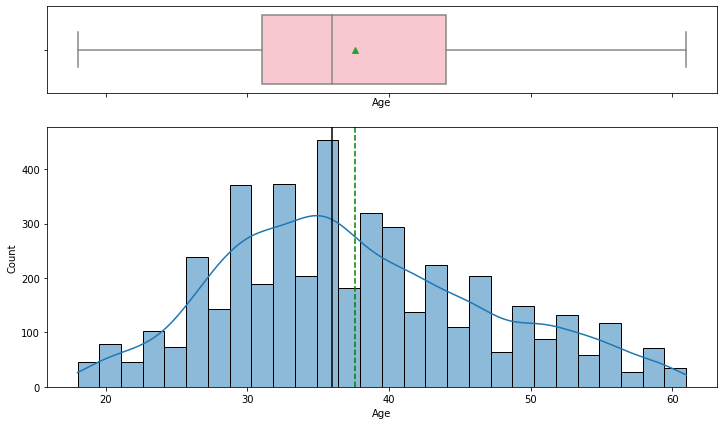

In [ ]:
histogram_boxplot(tour, 'Age')

In [ ]:
tour['Age'].describe()

count    4531.000000
mean       37.585522
std         9.328723
min        18.000000
25%        31.000000
50%        36.000000
75%        44.000000
max        61.000000
Name: Age, dtype: float64

In [ ]:
tour['Age'].skew()

0.37534693557990756

**DECISION:** Age is very slightly positively skewed, close to normal distribution. Therefore, I will impute missing values with the mean value of age. If it was highly skewed, I would use median value of the age to prevent the bias coming from outliers that make the data skewed. 

In [ ]:
tour['Age'].fillna(tour['Age'].mean(), inplace=True)

In [ ]:
tour['Age'].describe()

count    4747.000000
mean       37.585522
std         9.113967
min        18.000000
25%        31.000000
50%        37.000000
75%        43.000000
max        61.000000
Name: Age, dtype: float64

In [ ]:
tour['Age'].skew()

0.3841836815053066

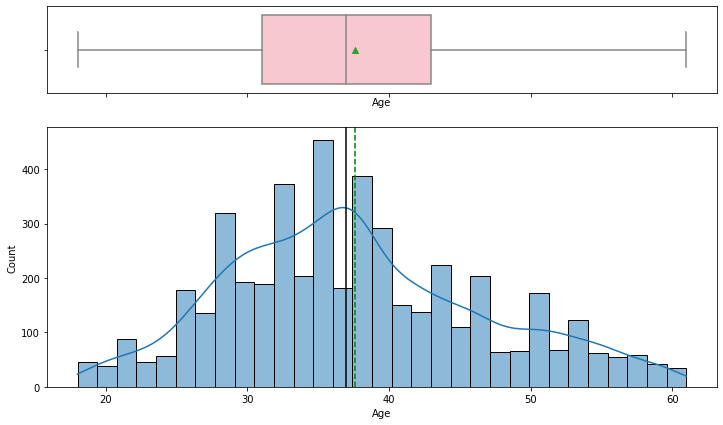

In [ ]:
histogram_boxplot(tour, 'Age')

**Interpretation:** The change in descriptive values and the shape of the boxplot and histogram is very slight, which is good, because it means that the imputation did not distort the data.

##Duration of Pitch##

There are 246 missing values in Duration of Pitch. There is no pattern in missingness. First, we should decide how to impute them or whether we should impute them.

In [ ]:
tour['DurationOfPitch'].describe()

count    4501.000000
mean       15.510998
std         8.535634
min         5.000000
25%         9.000000
50%        13.000000
75%        20.000000
max       127.000000
Name: DurationOfPitch, dtype: float64

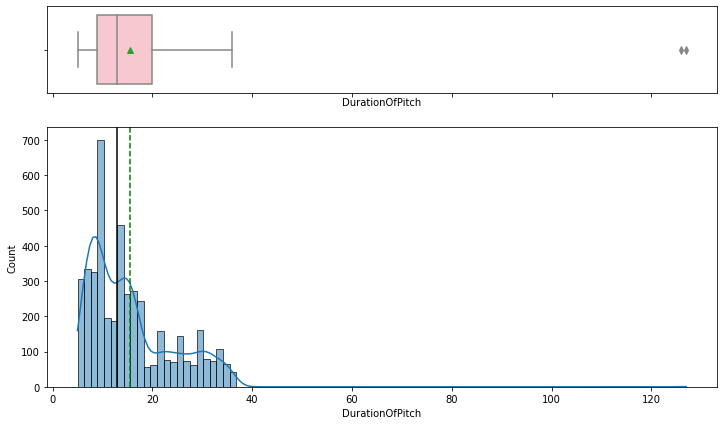

In [ ]:
histogram_boxplot(tour, 'DurationOfPitch')

In [ ]:
tour['DurationOfPitch'].skew()

1.7652273240618341

There are some critical outliers that dramatically impact the mean value of the variable. I will locate those outliers.

In [ ]:
tour.loc[tour['DurationOfPitch']>50]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
1434,0,37.585522,Company Invited,3,126.0,Salaried,Male,2,3.0,Basic,3.0,Married,3.0,0,1,1,1.0,Executive,18482.0
3808,0,53.000000,Company Invited,3,127.0,Salaried,Male,3,4.0,Basic,3.0,Married,4.0,0,1,1,2.0,Executive,22160.0


**Decision:** There are two very extreme values which are 126 and 127. We do not know the unit of time for the variable, meaning that we do not know if it is 126 minutes or 126 hours. However, regardless of the unit of time or whether the outliers are meaningful or not, I will impute them with the mean, because benefit of imputing them outweighs the cost. Whereas the imputation of two values out of 4747 is not very important, even when they are meaningful, imputing them can greatly contribute to the normal distribution which is a critical statistical assumption to be met. Also, we do not know if it is meaningful or not. It may not be meaningful. The benefit outweighs the risk.

In [ ]:
tour['DurationOfPitch'].replace([126.0, 127.0], tour['DurationOfPitch'].mean(), inplace=True)

In [ ]:
tour['DurationOfPitch'].describe()

count    4501.000000
mean       15.461680
std         8.208507
min         5.000000
25%         9.000000
50%        13.000000
75%        20.000000
max        36.000000
Name: DurationOfPitch, dtype: float64

In [ ]:
tour['DurationOfPitch'].skew() # The skewness of the data has switched from highly skewed to moderately skewed, which is a great change.

0.9036075045589543

In [ ]:
# Now I will impute the missing values with the mean

tour['DurationOfPitch'].fillna(tour['DurationOfPitch'].mean(), inplace=True)

###Transformations: Comparison###

In [ ]:
tour['DurationOfPitch_log']=np.log(tour['DurationOfPitch'])

In [ ]:
tour['DurationOfPitch_log'].skew()

0.17156294521171192

In [ ]:
tour['DurationOfPitch_arcsin']=np.arcsinh(tour['DurationOfPitch'])
tour['DurationOfPitch_arcsin'].skew()

0.176386149605492

In [ ]:
tour['DurationOfPitch_sqrt']=np.sqrt(tour['DurationOfPitch'])
tour['DurationOfPitch_sqrt'].skew()

0.5606404729895744

**Decision:** I will go with log transformation, because it greatly reduced skewness and made it slightly skewed. Although arcsinh transformation similary reduced the skewness, it is a transformation that is more difficult to interpret. Square transformation was not that useful. I will drop the DurationOfPitch column and the other two columns.

In [ ]:
tour.drop(['DurationOfPitch','DurationOfPitch_arcsin','DurationOfPitch_sqrt'], axis=1, inplace=True)

In [ ]:
tour['Gender']=tour['Gender'].astype('category') # I have noticed that it has turned into object again, and I don't know why, so I am going to switch it to category again.

##Number of Person Visiting##

In [ ]:
tour['NumberOfPersonVisiting'].isnull().sum() # There are zero missing value.

0

In [ ]:
tour['NumberOfPersonVisiting'].describe()

count    4747.000000
mean        2.911734
std         0.724040
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: NumberOfPersonVisiting, dtype: float64

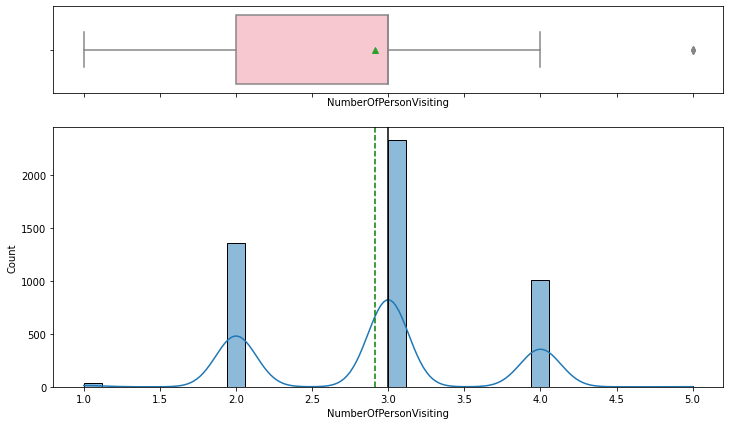

In [ ]:
histogram_boxplot(tour, 'NumberOfPersonVisiting')

In [ ]:
tour['NumberOfPersonVisiting'].skew()

0.028371857351674568

**Decision:** Data is almost normally distributed, so there is no need for transformation.

In [ ]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747 entries, 0 to 4746
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ProdTaken                 4747 non-null   category
 1   Age                       4747 non-null   float64 
 2   TypeofContact             4722 non-null   category
 3   CityTier                  4747 non-null   category
 4   Occupation                4747 non-null   category
 5   Gender                    4747 non-null   category
 6   NumberOfPersonVisiting    4747 non-null   int64   
 7   NumberOfFollowups         4703 non-null   float64 
 8   ProductPitched            4747 non-null   category
 9   PreferredPropertyStar     4721 non-null   float64 
 10  MaritalStatus             4747 non-null   category
 11  NumberOfTrips             4609 non-null   float64 
 12  Passport                  4747 non-null   category
 13  PitchSatisfactionScore    4747 non-null   int64 

##Number of Follow-ups##

In [ ]:
tour['NumberOfFollowups'].isnull().sum() # There are 44 missing values, so I will handle them.

44

In [ ]:
tour['NumberOfFollowups'].describe()

count    4703.000000
mean        3.705082
std         1.008677
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         6.000000
Name: NumberOfFollowups, dtype: float64

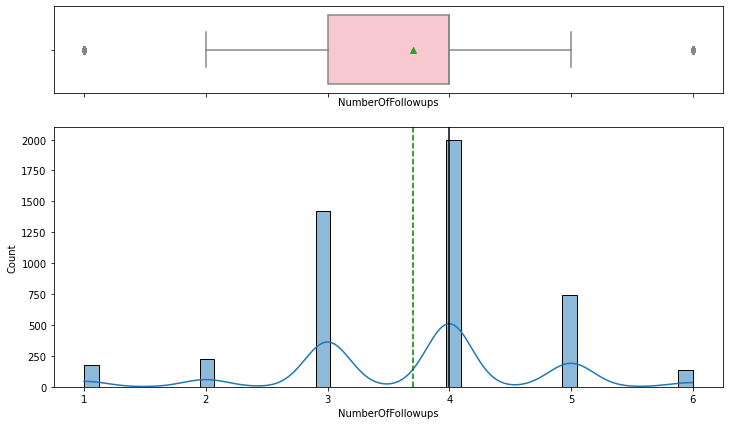

In [ ]:
histogram_boxplot(tour, 'NumberOfFollowups')

In [ ]:
tour['NumberOfFollowups'].skew() # Slightly positively skewed, so I will impute the missing values with the mean value

-0.3714686629879119

In [ ]:
tour['NumberOfFollowups'].fillna(tour['NumberOfFollowups'].mean(), inplace=True)

###Transformations##

In [ ]:
tour['NumberOfFollowups_log']=np.log(tour['NumberOfFollowups'])
tour['NumberOfFollowups_log'].skew()

-1.8425823451882293

In [ ]:
tour['NumberOfFollowups_sqrt']=np.sqrt(tour['NumberOfFollowups'])
tour['NumberOfFollowups_sqrt'].skew()

-1.0423797177049903

In [ ]:
tour['NumberOfFollowups_arcsin']=np.arcsinh(tour['NumberOfFollowups'])
tour['NumberOfFollowups_arcsin'].skew()

-1.5880197331599548

**Decision:** All three types of transformation have made the skewness way worse. Therefore, I will stick with the original variable and drop the newly created columns

In [ ]:
tour.drop(['NumberOfFollowups_log','NumberOfFollowups_sqrt','NumberOfFollowups_arcsin'], axis=1, inplace=True)

##Preferred Property Star##

In [ ]:
tour['PreferredPropertyStar'].isnull().sum() # There 26 missing values

26

In [ ]:
tour['PreferredPropertyStar'].describe()

count    4721.000000
mean        3.583351
std         0.800351
min         3.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: PreferredPropertyStar, dtype: float64

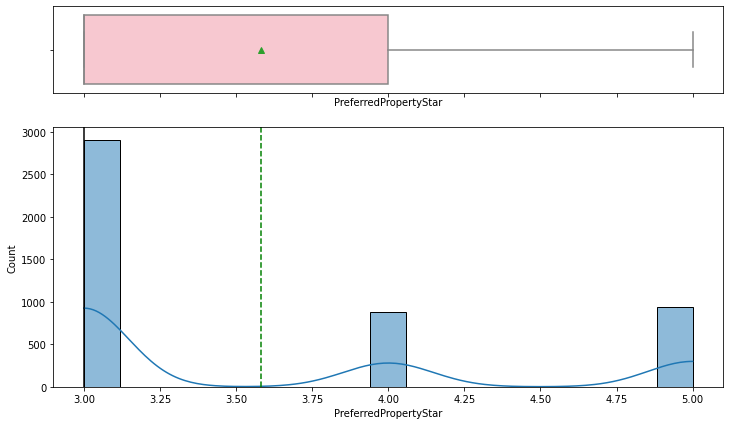

In [ ]:
histogram_boxplot(tour, 'PreferredPropertyStar')

In [ ]:
tour['PreferredPropertyStar'].skew() # Since there is not high skewness, I will use the mean value to impute missing values

0.890367419710427

In [ ]:
tour['PreferredPropertyStar'].fillna(tour['PreferredPropertyStar'].mean(), inplace=True)

###Transformations###

In [ ]:
tour['PreferredPropertyStar_log']=np.log(tour['PreferredPropertyStar'])
tour['PreferredPropertyStar_log'].skew()

0.7903158986220357

In [ ]:
tour['PreferredPropertyStar_sqrt']=np.sqrt(tour['PreferredPropertyStar'])
tour['PreferredPropertyStar_sqrt'].skew()

0.8402634809165824

In [ ]:
tour['PreferredPropertyStar_arcsin']=np.arcsinh(tour['PreferredPropertyStar'])
tour['PreferredPropertyStar_arcsin'].skew()

0.7963818907862921

**Decision:** All trnasformations have reduced skewness very slightly. To make the interpretation of the variable easier, I will keep the original column and remove the transformation columns.

In [ ]:
tour.drop(['PreferredPropertyStar_log','PreferredPropertyStar_sqrt','PreferredPropertyStar_arcsin'], axis=1, inplace=True)

##Number of Trips##

In [ ]:
tour['NumberOfTrips'].isnull().sum() # There are 138 missing values.

138

In [ ]:
tour['NumberOfTrips'].describe()

count    4609.000000
mean        3.233239
std         1.847851
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        22.000000
Name: NumberOfTrips, dtype: float64

In [ ]:
tour.loc[tour['NumberOfTrips']>10] # There are 4 very extreme outliers. However, I do not want to drop or impute them, because they do not seem reasonable based on other information on those specific customers.

,ProdTaken,Age,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,DurationOfPitch_log
385,1,30.0,Company Invited,1,Large Business,Male,2,3.0,Basic,3.0,Single,19.0,1,4,1,1.0,Executive,17285.0,2.302585
816,0,39.0,Company Invited,1,Salaried,Male,3,3.0,Deluxe,4.0,Unmarried,21.0,0,2,1,0.0,Manager,21782.0,2.708050
2759,1,31.0,Company Invited,1,Large Business,Male,3,4.0,Basic,3.0,Single,20.0,1,4,1,2.0,Executive,20963.0,2.397895
3190,0,40.0,Company Invited,1,Salaried,Male,4,4.0,Deluxe,4.0,Unmarried,22.0,0,2,1,1.0,Manager,25460.0,2.772589


In [ ]:
tour['NumberOfTrips'].skew() # It is highly skewed

1.4781161661452116

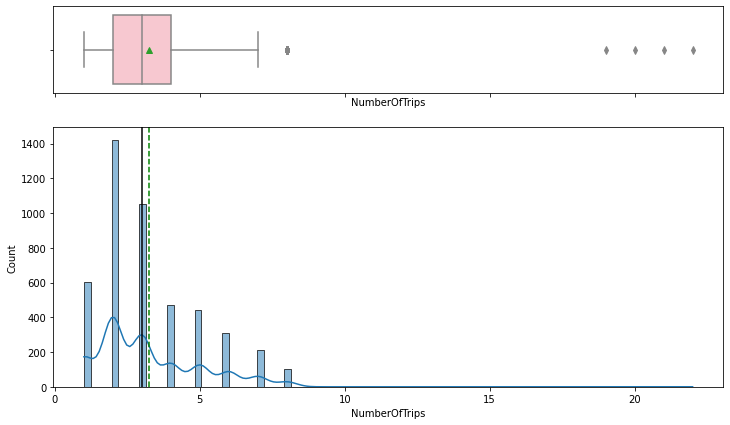

In [ ]:
histogram_boxplot(tour, 'NumberOfTrips')

In [ ]:
tour['NumberOfTrips'].fillna(tour['NumberOfTrips'].mean(), inplace=True)

In [ ]:
tour['NumberOfTrips'].skew() # Oddly, skewness has increased when I imputed the missing values with the mean value.

1.5000672093245246

###Transformations###

In [ ]:
tour['NumberOfTrips_log']=np.log(tour['NumberOfTrips'])
tour['NumberOfTrips_log'].skew()

-0.13947723166272902

In [ ]:
tour['NumberOfTrips_sqrt']=np.sqrt(tour['NumberOfTrips'])
tour['NumberOfTrips_sqrt'].skew()

0.5276082305962415

In [ ]:
tour['NumberOfTrips_arcsin']=np.arcsinh(tour['NumberOfTrips'])
tour['NumberOfTrips_arcsin'].skew()

0.03596176433207085

**Decision:** I will go with arcsinh transformation. Square transformation does not reduce skewness as much as the others. On the other hand, log transformation distorts the shape of the skewness by changing its direction, which is not good. Arcsinh transformation both reduced the skewness to a great extent and kept the shape of the distribution. Although arcsinh transformation is harder to interpret and explain, it is still the most reasonable option in this specific case.

In [ ]:
tour.drop(['NumberOfTrips_log','NumberOfTrips_sqrt','NumberOfTrips'], axis=1, inplace=True)

##Pitch Satisfaction Score##

In [ ]:
tour['PitchSatisfactionScore'].isnull().sum() # There is no missing value.

0

In [ ]:
tour['PitchSatisfactionScore'].skew() #It is slightly skewed, so I will not transform it for the sake of easier interpretation

-0.10240470913238622

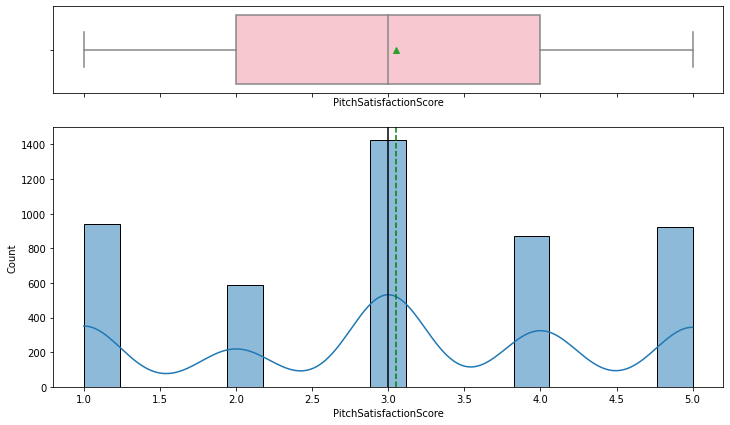

In [ ]:
histogram_boxplot(tour, 'PitchSatisfactionScore') # It is very close to normal distribution. There is no outlier.

##Number of Children Visiting##

In [ ]:
tour['NumberOfChildrenVisiting'].isnull().sum() # There are 60 missing values

60

In [ ]:
tour['NumberOfChildrenVisiting'].describe()

count    4687.000000
mean        1.193514
std         0.860461
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: NumberOfChildrenVisiting, dtype: float64

In [ ]:
tour['NumberOfChildrenVisiting'].skew() # It is slightly skewed, so I will not use transformation for the sake of easier interpretation.

0.2690458900110102

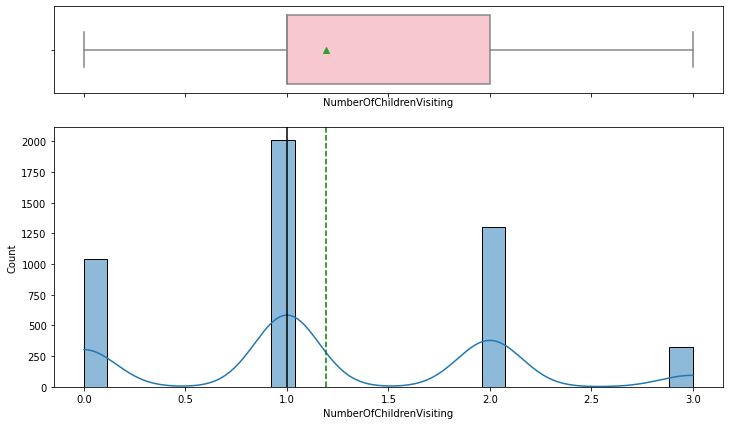

In [ ]:
histogram_boxplot(tour, 'NumberOfChildrenVisiting') # It is very close to normal distribution. There is no outlier.

In [ ]:
tour['NumberOfChildrenVisiting'].fillna(tour['NumberOfChildrenVisiting'].mean(), inplace=True) # I will impute missing values with the mean value

In [ ]:
tour['NumberOfChildrenVisiting'].isnull().sum()

0

In [ ]:
tour['NumberOfChildrenVisiting'].skew() # Skewness has very slightly changed, meaning that imputation did not distort the data, which is good news.

0.27076139535695587

##Monthly Income##

In [ ]:
tour['MonthlyIncome'].isnull().sum() # There are 224 missing values

224

In [ ]:
tour['MonthlyIncome'].skew() 

1.9807261748645977

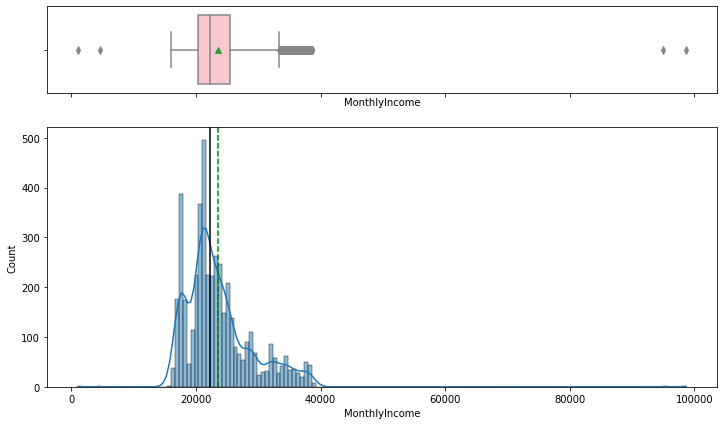

In [ ]:
histogram_boxplot(tour, 'MonthlyIncome')

Since it is highly skewed, I will use median for imputation not to bias the data by imputing the mean value that is influenced by outliers.

In [ ]:
tour['MonthlyIncome'].fillna(tour['MonthlyIncome'].median(), inplace=True)

In [ ]:
tour['MonthlyIncome'].skew() # Skewness has increased even further.

2.0549628876162593

In [ ]:
tour.loc[tour['MonthlyIncome']>50000]

,ProdTaken,Age,TypeofContact,CityTier,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,DurationOfPitch_log,NumberOfTrips_arcsin
38,0,36.0,Self Enquiry,1,Salaried,Female,2,4.0,Basic,3.583351,Divorced,1,2,1,0.0,Executive,95000.0,2.397895,0.881374
2412,0,37.0,Self Enquiry,1,Salaried,Female,3,5.0,Basic,5.000000,Divorced,1,2,1,1.0,Executive,98678.0,2.484907,1.443635


**Decision:** Although a monthly income of 95000 or 98000 is extraordinarily high, it is not impossible, especially given that their designation is executive. They may have other incomes from other sources as well. Therefore, I will not drop or impute them. 

###Transformations###

In [ ]:
tour['MonthlyIncome_log']=np.log(tour['MonthlyIncome'])
tour['MonthlyIncome_log'].skew()

-0.11277088738283135

In [ ]:
tour['MonthlyIncome_sqrt']=np.sqrt(tour['MonthlyIncome'])
tour['MonthlyIncome_sqrt'].skew()

1.064508508849243

In [ ]:
tour['MonthlyIncome_arcsin']=np.arcsinh(tour['MonthlyIncome'])
tour['MonthlyIncome_arcsin'].skew()

-0.11277071682877869

**Decision:** I will go with the log transformation. Although arcsinh reduced skewness similarly, it is a more complicated transformation and harder to interpret. On the other hand, square transformation was not as effective as log transformation in terms of reducing the skewness. Although log transformation distorted the data a bit by changing the direction of the skewness, it reduced the skewness so greatly that the slight distortion can be overlooked.

In [ ]:
# I should drop the original column as well, but I will do it later. First, I want to use it for bivariate analysis, because interpreting the plot of a non-transformed variable is easier. 
tour.drop(['MonthlyIncome_sqrt','MonthlyIncome_arcsin'], axis=1, inplace=True)

##Type of Contact## 

**Decision:** Only type of contact among all other categorical variables will be examined in Univariate Analysis section, because it has some missing values needed to be treated. Other categorical variables will be examined in Bivariate Analysis section, because I do not think that univariate analysis of categorical variables is not that important unless the variable needs to be preprocessed or have some missing variables. Their relation with one another or with a numerical variable is more important and meaningful for analysis.

In [ ]:
tour['TypeofContact'].isnull().sum() # There are 25 missing values

25

In [ ]:
tour['TypeofContact'].describe()

count             4722
unique               2
top       Self Enquiry
freq              3350
Name: TypeofContact, dtype: object

Whereas 70 percent of the variable is self-enquiry, 30 percent is Company Invited. Therefore, the mode is self-enquiry. Normally, I would want to fill the 70 percent of missing values with self-enquiry and the rest with company invited. However, because I do not how to do that in Python, I will just impute the missing values with the mode. 

In [ ]:
tour['TypeofContact'].fillna(tour['TypeofContact'].mode()[0], inplace=True)

In [ ]:
tour['TypeofContact'].describe()

count             4747
unique               2
top       Self Enquiry
freq              3375
Name: TypeofContact, dtype: object

#Bivariate Analysis#

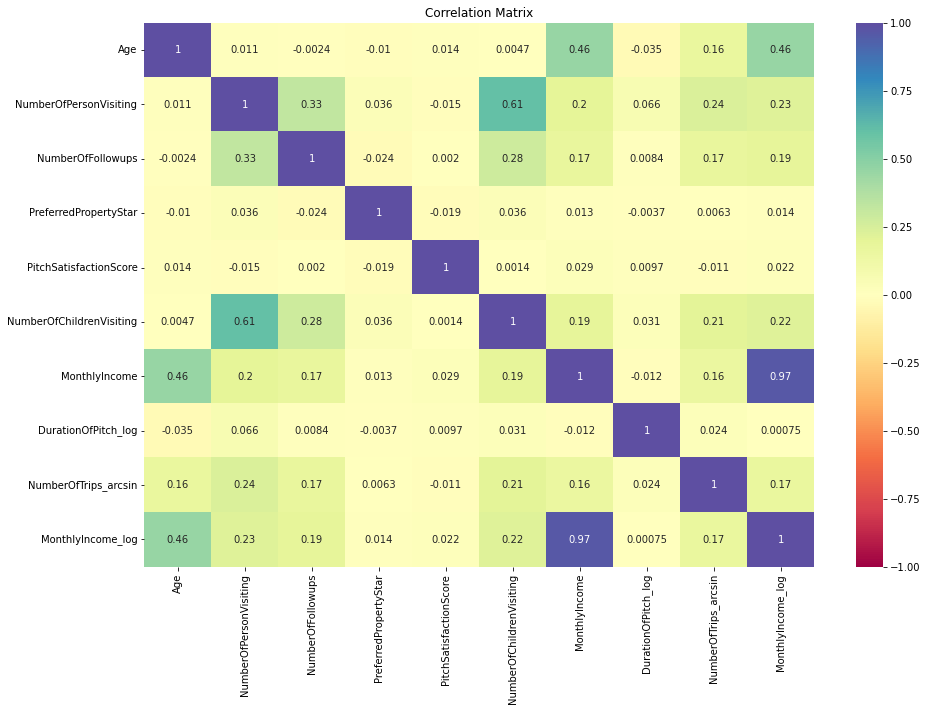

In [ ]:
# I will create a correlation matrix and a heatmap 

plt.figure(figsize=(15,10))
sns.heatmap(tour.corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Interpretation:** There is a very high positive correlation between Monthly Income and MonthlyIncome_log, which is expected. That is not a problem for the overall analysis, since I will drop the original Monthly Income after bivariate analysis. 

There is a moderate to high positive correlation between Number of Children Visiting and Number of Person Visiting, which is an expected outcome, because an increase in the number of children visiting naturally means an increase in the number of person visiting. Those two variable may even have multicollinearity which I am going to check. 

Also, there is a low to moderate positive correlation between Age and Monthly Income, which is expected again, because as age increases, a person becomes more experienced and senior in a company. In turn, that person gets more salary.

Finally, there is a low positive correlation between Number of Followups and Number of Person Visiting

**Multicollinearity:** There might be a multicollinearity issue between Number of Children Visiting and Number of Person Visiting. Multicollinearity happens when two variable correlate with each other extremely, which lead to interpretability issues, because multicollinearity prevents us from knowing how much a variable contributes to the result. On the other hand, I cannot know if it is really multicollinearity just by looking at a correlation matrix. To know it for sure, I should calculate variance inflation factor (VIF). I will check the multicollinearity between age and monthly income in any case as well.

In [ ]:
# Calculating VIF for numerical variables

import statsmodels.api as sm #It imports the necessary package
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = tour[list(tour[['NumberOfPersonVisiting','NumberOfChildrenVisiting']])]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
1,4.238646,NumberOfChildrenVisiting
0,4.238646,NumberOfPersonVisiting


**Decision:** Because VIF scores are below 5, I will not drop any of the two variables

In [ ]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747 entries, 0 to 4746
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ProdTaken                 4747 non-null   category
 1   Age                       4747 non-null   float64 
 2   TypeofContact             4747 non-null   category
 3   CityTier                  4747 non-null   category
 4   Occupation                4747 non-null   category
 5   Gender                    4747 non-null   category
 6   NumberOfPersonVisiting    4747 non-null   int64   
 7   NumberOfFollowups         4747 non-null   float64 
 8   ProductPitched            4747 non-null   category
 9   PreferredPropertyStar     4747 non-null   float64 
 10  MaritalStatus             4747 non-null   category
 11  Passport                  4747 non-null   category
 12  PitchSatisfactionScore    4747 non-null   int64   
 13  OwnCar                    4747 non-null   catego

Let's look at the relationship between our outcome variable which is ProdTaken and some other variables that I see relevant in this analysis.

##Product Taken vs. Age##

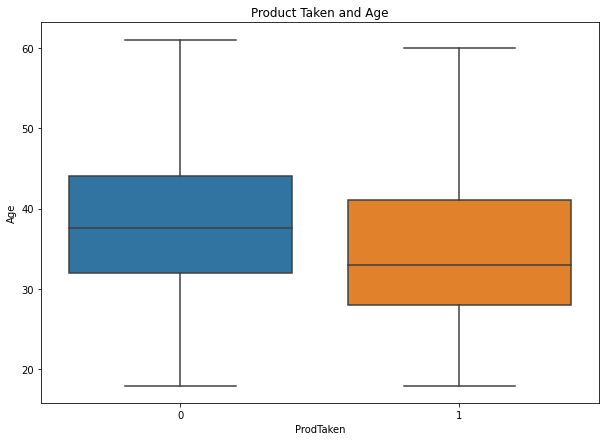

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='Age')
plt.title('Product Taken and Age')
plt.show();


The people who purchased a package was slighlty younger compared to those who did not.

##Product Taken vs. Number of Person Visiting##

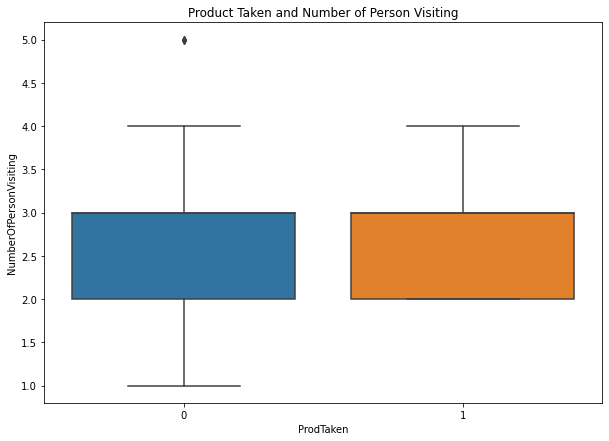

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='NumberOfPersonVisiting')
plt.title('Product Taken and Number of Person Visiting')
plt.show();


There is almost no difference between people who purchased the product and those who did not not in the context of number of person visiting. 

##Product Taken vs. Number of Followups##

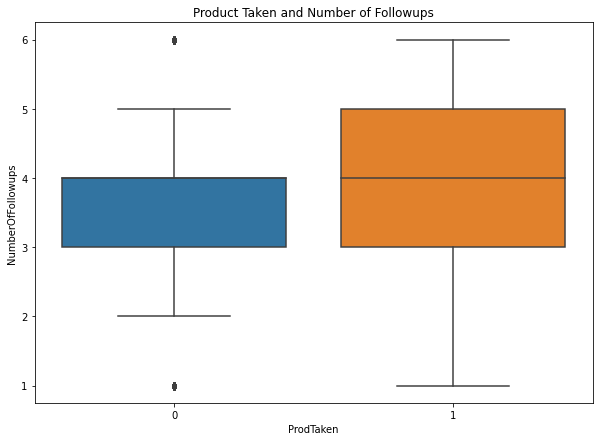

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='NumberOfFollowups')
plt.title('Product Taken and Number of Followups')
plt.show();

The people who purchased a package were those with whom a salesperson made more contact and followups after the sales pitch.

##Product Taken vs. Pitch Satisfaction Score##

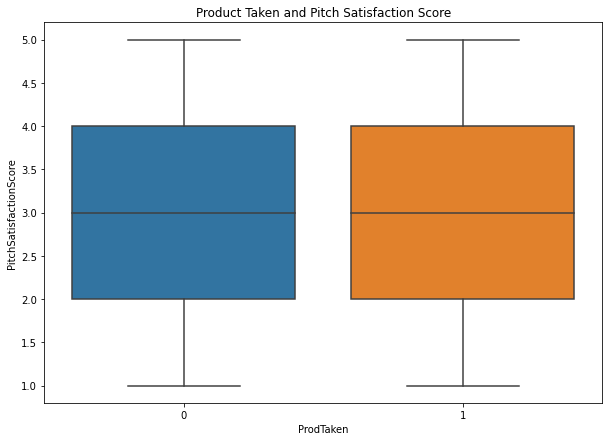

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='PitchSatisfactionScore')
plt.title('Product Taken and Pitch Satisfaction Score')
plt.show();

There is almost no difference between people who purchased the product and those who did not not in the context of how satisfied they were regarding the sales pitch. This is an interesting finding, because it shows that how satisfactory a customer perceives a sales pitch is not effective in the customer's decision for purchasing a package.

##Product Taken vs. Duration of Pitch##

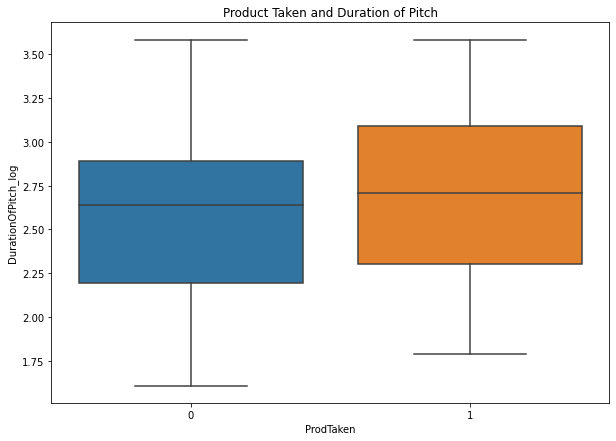

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='DurationOfPitch_log')
plt.title('Product Taken and Duration of Pitch')
plt.show();

Duration of sales pitch was slightly higher for the people who purchased a package.

##Product Taken vs. Number of Trips##

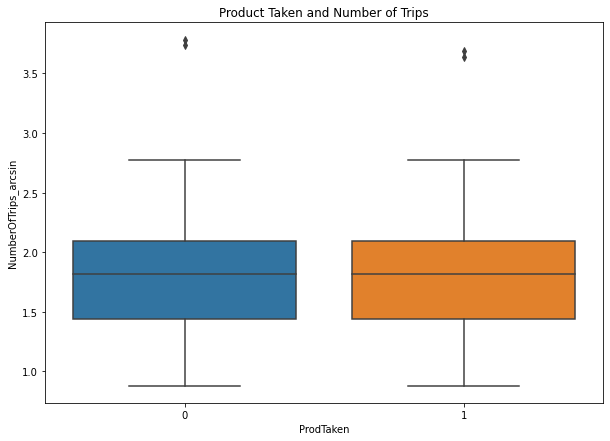

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='NumberOfTrips_arcsin')
plt.title('Product Taken and Number of Trips')
plt.show();

There is almost no difference between people who purchased the product and those who did not not in the context of their average number of trips in a year.

##Product Taken vs. Monthly Income##

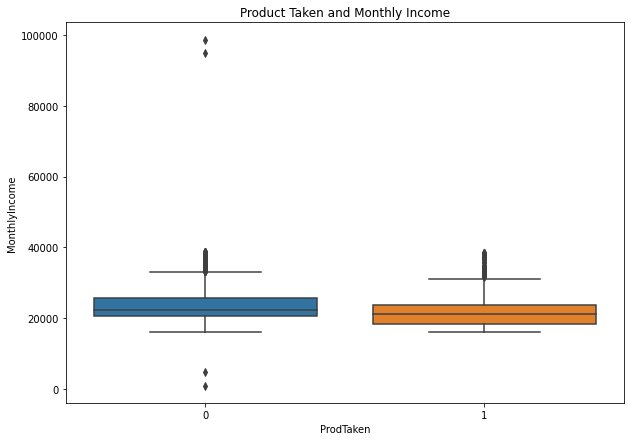

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProdTaken', y='MonthlyIncome')
plt.title('Product Taken and Monthly Income')
plt.show();

##Product Pitched vs. Monthly Income##

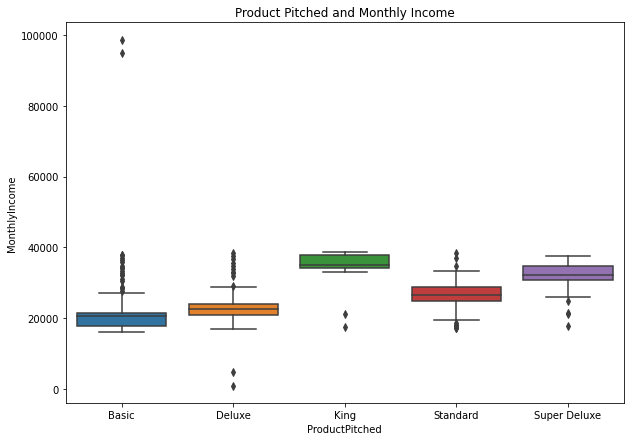

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(data=tour, x='ProductPitched', y='MonthlyIncome')
plt.title('Product Pitched and Monthly Income')
plt.show();

##Product Taken vs. Product Pitched##

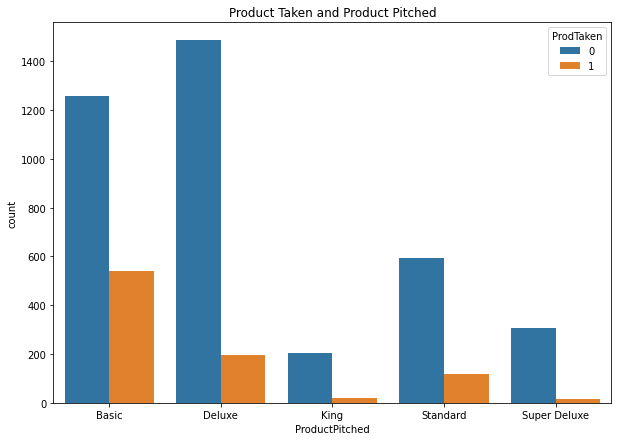

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(data=tour, x='ProductPitched', hue='ProdTaken')
plt.title('Product Taken and Product Pitched')
plt.show();

##Product Taken, Monthly Income, and Product Pitched##

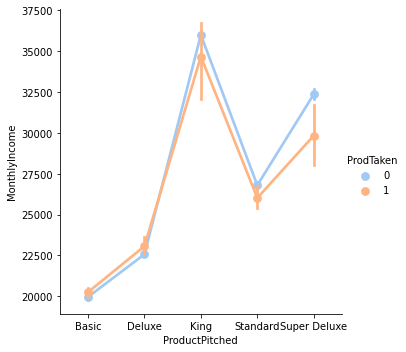

In [ ]:
sns.catplot(data=tour, x='ProductPitched', y='MonthlyIncome', hue='ProdTaken', kind='point', palette='pastel');

##Product Pitched vs. Gender

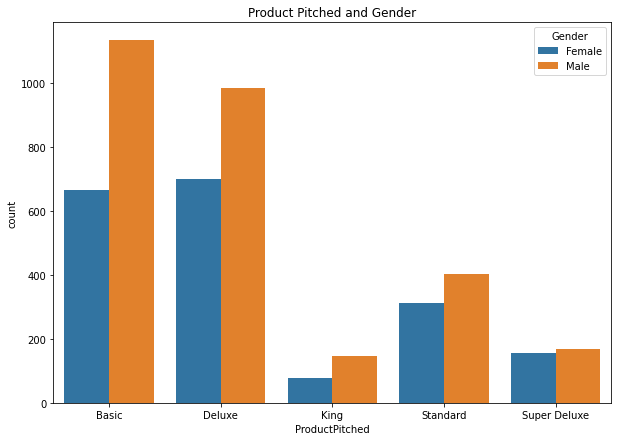

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(data=tour, x='ProductPitched', hue='Gender')
plt.title('Product Pitched and Gender')
plt.show();

##Product Pitched vs. Passport##

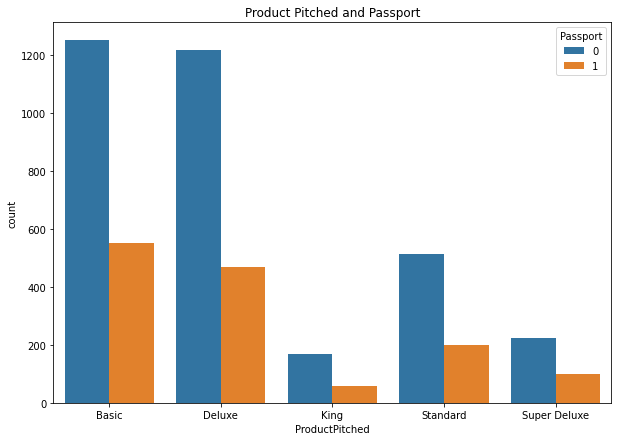

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot(data=tour, x='ProductPitched', hue='Passport')
plt.title('Product Pitched and Passport')
plt.show();

**Insights**

1) People who have no passports are almost twice more likely to purchase one of the five products, and this pattern is similar for each product. It may be because that people who have passport prefer to visit other countries rather than visiting in-country (I assume that the company 'Visit with us' does not offer options for visiting foreign countries. If they provided, there would not be much difference in the context of having a passport). 

2) Males are more likely to purchase one of the five products, and this patter is similar for most of the products. Only Super Deluxe is a bit different. There is almost no gender difference in terms of purchasing that package. The difference is almost twice in King package, males being twice more likely to purchase it. 

3) As expected, monthly income and product pitched is positively correlated, meaning that more expensive packages like King are purchased by those with higher income.

#Model Building and Testing#

##Creating Dummy Variables##

In [ ]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747 entries, 0 to 4746
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ProdTaken                 4747 non-null   category
 1   Age                       4747 non-null   float64 
 2   TypeofContact             4747 non-null   category
 3   CityTier                  4747 non-null   category
 4   Occupation                4747 non-null   category
 5   Gender                    4747 non-null   category
 6   NumberOfPersonVisiting    4747 non-null   int64   
 7   NumberOfFollowups         4747 non-null   float64 
 8   ProductPitched            4747 non-null   category
 9   PreferredPropertyStar     4747 non-null   float64 
 10  MaritalStatus             4747 non-null   category
 11  Passport                  4747 non-null   category
 12  PitchSatisfactionScore    4747 non-null   int64   
 13  OwnCar                    4747 non-null   catego

In [ ]:
tour=pd.get_dummies(tour, columns=['TypeofContact','CityTier','Occupation','Gender','ProductPitched','MaritalStatus','Passport','OwnCar','Designation'], drop_first=True)

In [ ]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4747 entries, 0 to 4746
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   ProdTaken                    4747 non-null   category
 1   Age                          4747 non-null   float64 
 2   NumberOfPersonVisiting       4747 non-null   int64   
 3   NumberOfFollowups            4747 non-null   float64 
 4   PreferredPropertyStar        4747 non-null   float64 
 5   PitchSatisfactionScore       4747 non-null   int64   
 6   NumberOfChildrenVisiting     4747 non-null   float64 
 7   MonthlyIncome                4747 non-null   float64 
 8   DurationOfPitch_log          4747 non-null   float64 
 9   NumberOfTrips_arcsin         4747 non-null   float64 
 10  MonthlyIncome_log            4747 non-null   float64 
 11  TypeofContact_Self Enquiry   4747 non-null   uint8   
 12  CityTier_2                   4747 non-null   uint8   
 13  Cit

##Splitting the Data##

In [ ]:
# Identifying the X and Y variables

X = tour.drop("ProdTaken", axis=1)
Y = tour["ProdTaken"]

In [ ]:
# Splitting the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

##Functions for Confusion Matrix and Calculating Metrics##

In [ ]:
## The below function will allow us to create a confusion matrix

def make_confusion_matrix(model,y_actual,labels=[1, 0]): # model refers to the type of classifier we are going to use, whereas y_actual usually refers to y_test, the ground truth
    
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# The function below will allow us the calculate metrics for different models

def get_metrics_score(model,flag=True):
    
    score_list=[]  # This empty list is used to store previous train and test results
    
    # Calculating predictions

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Calculating the accuracy
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    # Calculating the recall
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    # Calculating the precision

    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    
    if flag == True:  # # We use flag==True to display the print statements below, and only they will be displayed.

        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list

##Decision on Recall and Precision##

The models I am going to build can make a wrong prediction in the following ways:

1- A model can predict that a customer will purchase the product, but in fact, he will not purchase it (False Positive)

2- The model can predict a customer will not purchase the product, but in fact, he will purchase it (False Negative)

Which loss is greater?

The second loss is greater, because the primary aim of the tourism company is to detect potential customers that will buy their Wellness Tourism Package. There is not much risk in the case of false positive. A salesman can waste some time and resource to convince a customer that is falsely expected to buy a purchase, but in fact he does not buy, and the only loss would be some time and resource the salesman is going to use. On the other hand, in the case of false negative, the company will fail to sell more of their new packages just because they wrongly conclude that a customer will not purchase the product, while in fact he would do that, if a salesperson has made a contact with him.

How can we reduce the loss resulting from false negatives? The probability of false negatives is reduced by increasing Recall score which is (TP/(TP+FN), meaning that as True Positive (hence, Recall) increases, False Negative decreases.

In conclusion, although I will calculate all the three scores of accuracy, recall, and precision, I will primarily use recall when making a decision about the effectiveness of a model.

##Bagging Classifier with Decision Tree##

In [ ]:
# Decision tree is the default estimator for bagging classifier, meaning that unless I write random forest or something else, it will create a decision tree
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [ ]:
# I use the function that I created above to calculate the metrics score of a model for bagging classifier

bagging_estimator_score=get_metrics_score(bagging_estimator)

Accuracy on training set :  0.9918723660445514
Accuracy on test set :  0.9059649122807018
Recall on training set :  0.9594155844155844
Recall on test set :  0.60431654676259
Precision on training set :  0.9966273187183811
Precision on test set :  0.875


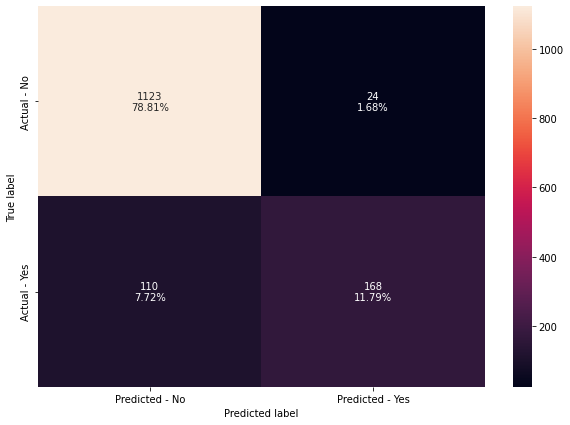

In [ ]:
make_confusion_matrix(bagging_estimator,y_test)

**Interpretation:** The recall score on training set is .95 which seems very good, but in fact, the default decision tree model of bagging classifier dramatically overfits in this case, because there is a .35 difference between the recall score of training set and that of testing set, the latter' score being only .60. It means that there is a huge overfit problem here, meaning that this model captures not only the data itself, but also most of the noise as well. 

Also, the confusion matrix show that 110 people (7.72%) were predicted to not purchase the Wellness Tourism Package, while in fact they would have purchased it if a salesperson had tried to sell them the package. 

##Bagging Classifier with Logistic Regression##

In [ ]:
bagging_lr=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear',random_state=1,max_iter=1000),random_state=1)
bagging_lr.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                    random_state=1,
                                                    solver='liblinear'),
                  random_state=1)

In [ ]:
bagging_lr_score=get_metrics_score(bagging_lr)

Accuracy on training set :  0.8145695364238411
Accuracy on test set :  0.8049122807017544
Recall on training set :  0.0
Recall on test set :  0.0
Precision on training set :  0.0
Precision on test set :  0.0


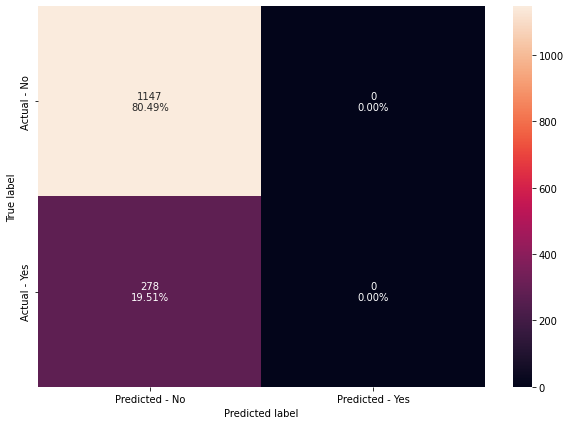

In [ ]:
make_confusion_matrix(bagging_lr ,y_test)

**Interpretation:** Using Logistic Regression as a base estimator in Bagging Classifier was completely useless in this dataset, and the percentage of false negative was even higher (19.51%)

##Random Forest Classifier##

In [ ]:
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [ ]:
rf_estimator_score=get_metrics_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.8968421052631579
Recall on training set :  1.0
Recall on test set :  0.5287769784172662
Precision on training set :  1.0
Precision on test set :  0.901840490797546


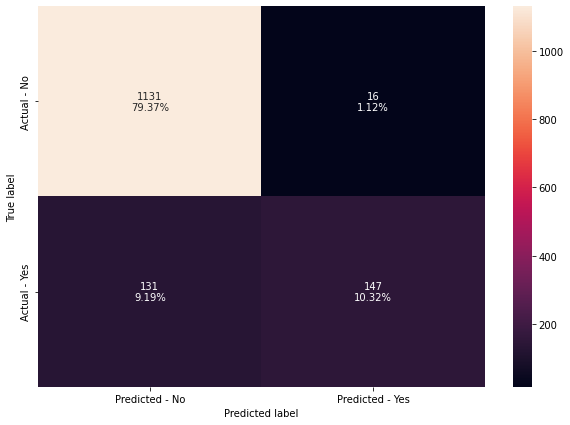

In [ ]:
make_confusion_matrix(rf_estimator,y_test)

**Interpretation:** The random forest model is even worse than the bagging classifier with decision tree model. The recall score on training set is 1, whereas the same score on test set is only .52. There is a difference of .48 between them, indicating the huge overfitting of the testing model. It captures the noise in the dataset a lot.

Also, the percentage of the false negative was higher compared to bagging classifier with decision tree model as well, which is a bad thing, because we want to decrease that as much as possible.

##Hyperparameter Tuning##

###Bagging Classifier - Tuning###

In [ ]:
# First, I will choose the type of classifier which is bagging classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Below is the grid of parameters from which the best combination for the model will be selected

parameters = {
              'max_samples': [0.6,0.7,0.8,0.9], 
              'max_features': [0.6,0.7,0.8,0.9],
              'n_estimators' : [20,30,40,50,60],
             }

# I will choose the type of scoring that will be used to compare parameter combinations. The type of scoring will be recall, and I wrote above that why recall is more important in this specific case.
acc_scorer = metrics.make_scorer(metrics.recall_score)

# The code below runs the grid search created above

grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# The code below will determine the best combination from the parameter values listed above

bagging_estimator_tuned = grid_obj.best_estimator_

# The code below will fit the best algorithm to the data

bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=60,
                  random_state=1)

The output above shows the best combination of parameter values that will create the model that best captures the data 

In [ ]:
bagging_estimator_tuned_score=get_metrics_score(bagging_estimator_tuned)

Accuracy on training set :  1.0
Accuracy on test set :  0.9171929824561403
Recall on training set :  1.0
Recall on test set :  0.6366906474820144
Precision on training set :  1.0
Precision on test set :  0.9123711340206185


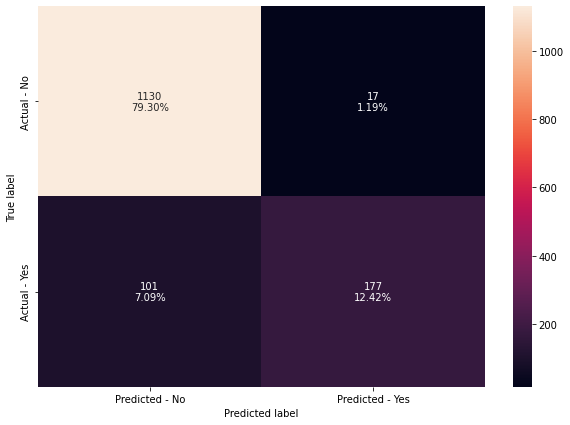

In [ ]:
make_confusion_matrix(bagging_estimator_tuned,y_test)

**Interpretation:** The tuned model is not still good in terms of overfitting. Although the recall score for both training and test sets increased, the difference between them remained similar and huge, indicating the same overfitting problem. 

Also, confusion matrix shows that there is only a very slight amount of decrease in the percentage of false negatives. It has been reduced from 7.72% to 7.09%.

###Random Forest Classifier - Tuning###

In [ ]:
rf_estimator_tuned = RandomForestClassifier(random_state=1)

parameters = {'n_estimators': [100, 150],
    'min_samples_leaf': np.arange(5,8),
    'max_features': np.arange(0.5, 0.7, 0.1),
    'max_samples': np.arange(0.5, 0.7, 0.1),
 
             }

acc_scorer = metrics.make_scorer(metrics.recall_score)


grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)


rf_estimator_tuned = grid_obj.best_estimator_


rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features=0.6, max_samples=0.6, min_samples_leaf=5,
                       n_estimators=150, random_state=1)

**NOTE:** Above, I tried to use different parameters and more values in each parameter, but it was taking so much time, analysis not finishing, so I had to use less parameters and less values.

In [ ]:
rf_estimator_tuned_score=get_metrics_score(rf_estimator_tuned)

Accuracy on training set :  0.9045755568934377
Accuracy on test set :  0.856140350877193
Recall on training set :  0.5340909090909091
Recall on test set :  0.34532374100719426
Precision on training set :  0.9164345403899722
Precision on test set :  0.8067226890756303


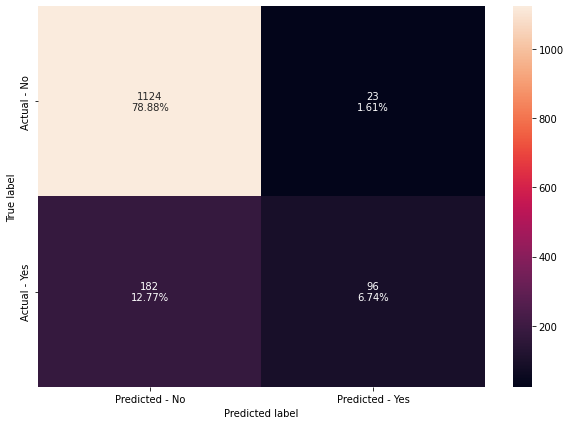

In [ ]:
make_confusion_matrix(rf_estimator_tuned,y_test)

**Interpretation:** Overfitting is significantly reduced compared to tuned bagging model. There is a difference of 19% percent between recall on training set and recall on test set, which was nearly 37% in the tuned bagging model. However, the recall score in this tuned random forest model is significantly lower than the one in the tuned bagging model for both train and test sets. Confirming that, confusion matrix shows that the false negative percentage has increased from 7.09% to 12.77% from tuned bagging model to tuned random forest model.

###Random Forest with Class Weight###

In [ ]:
tour['ProdTaken'].value_counts()

0    3853
1     894
Name: ProdTaken, dtype: int64

The default parameter for class weight is 1, meaning that both the purchasers and non-purchasers would be given the weight of 1 during analysis. However, we know that, in fact, nearly 20% of the values in ProdTaken is purchasers and 80% is non-purchasers. We should take into account that imbalance during analysis.

In [ ]:
rf_estimator_weighted = RandomForestClassifier(random_state=1)

parameters = {
'class_weight': [{0: 0.8, 1: 0.2}],
'n_estimators': [100, 150],
    'min_samples_leaf': np.arange(5,8),
    'max_features': np.arange(0.5, 0.7, 0.1),
    'max_samples': np.arange(0.5, 0.7, 0.1),
 
             }

acc_scorer = metrics.make_scorer(metrics.recall_score)


grid_obj = GridSearchCV(rf_estimator_weighted, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)


rf_estimator_weighted = grid_obj.best_estimator_


rf_estimator_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.8, 1: 0.2}, max_features=0.6,
                       max_samples=0.6, min_samples_leaf=5, random_state=1)

In [ ]:
rf_estimator_weighted_score=get_metrics_score(rf_estimator_weighted)

Accuracy on training set :  0.863937387116195
Accuracy on test set :  0.8329824561403508
Recall on training set :  0.2694805194805195
Recall on test set :  0.16546762589928057
Precision on training set :  0.9880952380952381
Precision on test set :  0.8846153846153846


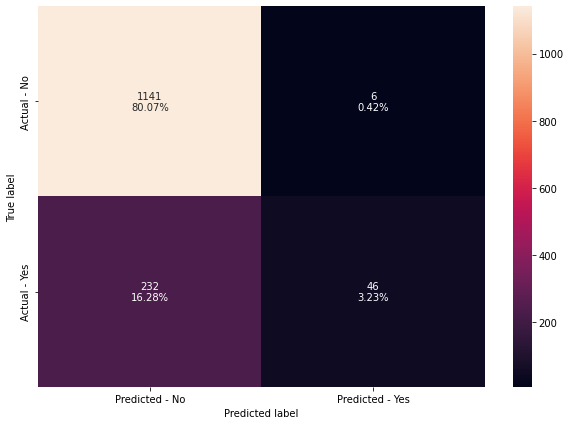

In [ ]:
make_confusion_matrix(rf_estimator_weighted,y_test)

**Interpretation:** The issue of overfitting was reduced further, having a difference of 10%. However, the recall score both on training and test sets are extremely low, and the percentage of false negative increased further. This is definitely not a good model for our purposes. 

##Comparing the models: Part 1##

In [ ]:
models = [bagging_estimator,bagging_estimator_tuned,bagging_lr,rf_estimator,rf_estimator_tuned,
          rf_estimator_weighted]

acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [ ]:
comparison_frame = pd.DataFrame({'Model':['Bagging with Decision Tree','Bagging - Tuned',
                                        'Bagging with Logistic Regression', 'Random Forest - Default',
                                         'Random Forest - Tuned','Random Forest - Weighted'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Bagging with Decision Tree,0.99,0.91,0.96,0.60,1.00,0.88
1,Bagging - Tuned,1.00,0.92,1.00,0.64,1.00,0.91
2,Bagging with Logistic Regression,0.81,0.80,0.00,0.00,0.00,0.00
3,Random Forest - Default,1.00,0.90,1.00,0.53,1.00,0.90
4,Random Forest - Tuned,0.90,0.86,0.53,0.35,0.92,0.81
5,Random Forest - Weighted,0.86,0.83,0.27,0.17,0.99,0.88


**Decision:** It is very difficult to select one of the models from the output above, because none of them provides a good model. Each has overfitting problem, and those with the least overfitting has increased false negatives which is contrary to the purposes of this analysis. The company wants to successful detect the potential customers that would buy their new package. Therefore, our model should not miss the those potential customers by defining them as non-purchasers. I will make the final decision after boosting analysis.

##Boosting: AdaBoost, Default##

Boosting includes three types which are AdaBoosting, Gradient Boosting, and XGBoost. However, I may not use XGBoost in this analysis in case that it takes so much time, and my computer is a bit old. The coding process for each of them is mostly similar to bagging, but the results and interpretation would be different.

In [ ]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [ ]:
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.8588199879590608
Accuracy on test set :  0.8385964912280702
Recall on training set :  0.3522727272727273
Recall on test set :  0.32014388489208634
Precision on training set :  0.7560975609756098
Precision on test set :  0.6846153846153846


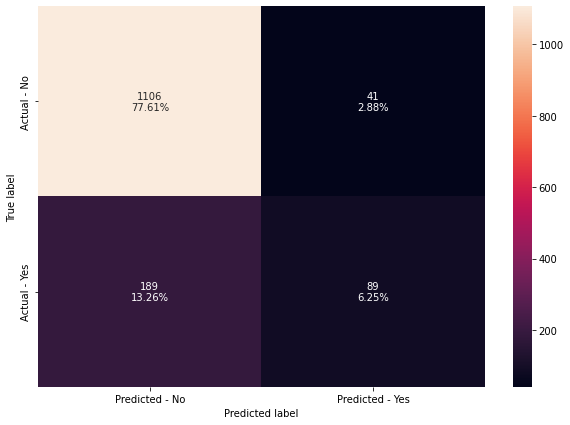

In [ ]:
make_confusion_matrix(abc,y_test)

**Interpretation:** Overfitting is greatly reduced compared to any bagging or random forest model created above, because there is a difference of only 3 percent between the recall score on testing data and that on training data. However, the recall score is still significantly low, meaning that the percentage of false negative is high (13.26%).

##Boosting: Gradient Boosting, Default##

In [ ]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [ ]:
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  0.8919325707405178
Accuracy on test set :  0.8505263157894737
Recall on training set :  0.48538961038961037
Recall on test set :  0.34532374100719426
Precision on training set :  0.8768328445747801
Precision on test set :  0.7559055118110236


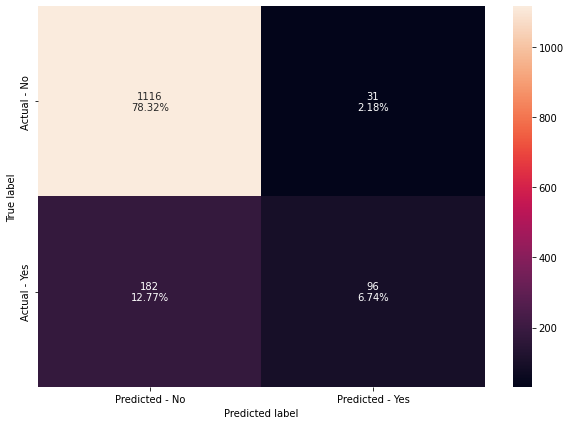

In [ ]:
make_confusion_matrix(gbc,y_test)

**Interpretation:** Recall score has increased, especially for training data, but in turn, the chance of data being overfitted increased from 3 percent to 14 percent. 

##Boosting: XGBoost, Default##

In [ ]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', random_state=1)

In [ ]:
xgb_score=get_metrics_score(xgb)

Accuracy on training set :  0.8853100541842264
Accuracy on test set :  0.8505263157894737
Recall on training set :  0.4496753246753247
Recall on test set :  0.33093525179856115
Precision on training set :  0.8683385579937304
Precision on test set :  0.773109243697479


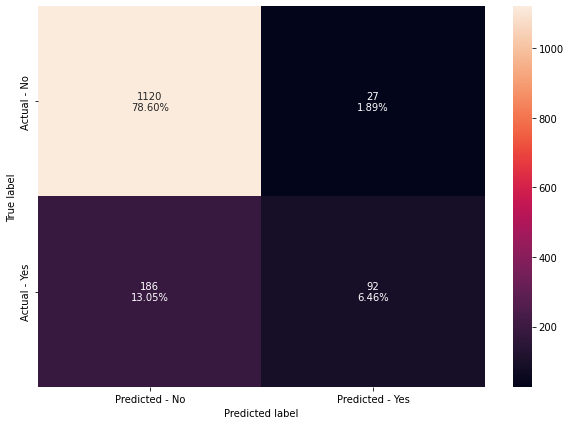

In [ ]:
make_confusion_matrix(xgb,y_test)

**Interpretation:** Overfitting issue is better compared to Gradient Boosting, but worse compared to AdaBoost. On the other hand, recall score is lower compared to Gradient Boosting, but higher compared to AdaBoost. In other words, XGBoost provides a more balanced model.

##Boosting: AdaBoost, Tuned##

In [ ]:
abc_tuned = AdaBoostClassifier(random_state=1)
parameters = {
    "n_estimators": np.arange(50,100,10),
    "learning_rate":np.arange(0.1,1.6,0.2),
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1)]
}

acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

abc_tuned = grid_obj.best_estimator_

abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1.3000000000000003, n_estimators=80,
                   random_state=1)

In [ ]:
abc_tuned_score=get_metrics_score(abc_tuned)

Accuracy on training set :  0.9804334738109572
Accuracy on test set :  0.8680701754385964
Recall on training set :  0.9253246753246753
Recall on test set :  0.5719424460431655
Precision on training set :  0.967741935483871
Precision on test set :  0.6973684210526315


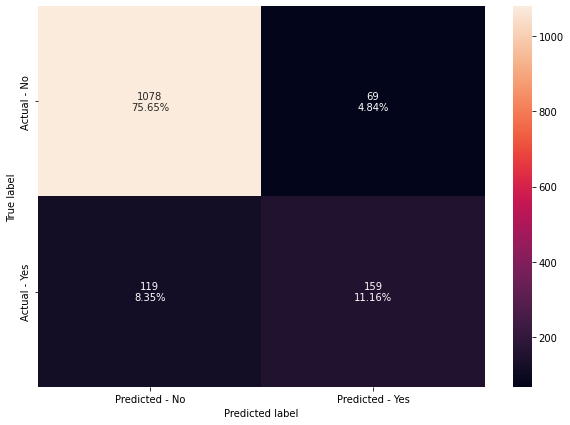

In [ ]:
make_confusion_matrix(abc_tuned,y_test)

**Interpretation:** The recall scores on training set and testing set have increased a lot for sure, and the matrix shows that the percentage of false negative has reduced compared to previous boosting models. However, the difference between the recall score on training and that on testing has significantly increased to 35%. It shows that there is an important overfitting issue in the model, meaning that it captures not only the data, but also the noise within data.

##Boosting: Gradient Boosting, Tuned##

In [ ]:
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

parameters = {
    "n_estimators": [100,150,200],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9]
}

acc_scorer = metrics.make_scorer(metrics.recall_score)

grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

gbc_tuned = grid_obj.best_estimator_

gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.9, n_estimators=200, random_state=1,
                           subsample=0.8)

In [ ]:
gbc_tuned_score=get_metrics_score(gbc_tuned)

Accuracy on training set :  0.9139072847682119
Accuracy on test set :  0.8673684210526316
Recall on training set :  0.5941558441558441
Recall on test set :  0.43884892086330934
Precision on training set :  0.9104477611940298
Precision on test set :  0.7870967741935484


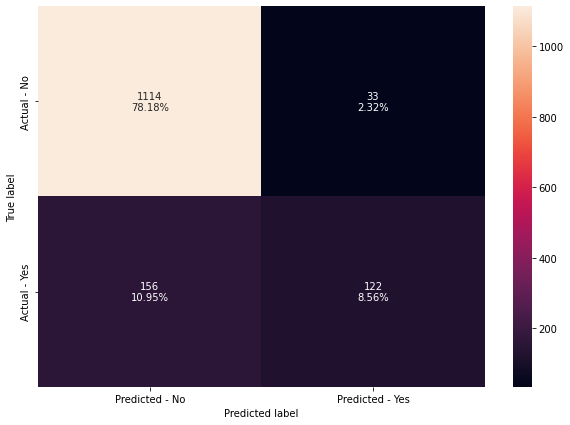

In [ ]:
make_confusion_matrix(gbc_tuned,y_test)

**Interpretation:** This model has still some overfitting problems, but the recall score is higher than the previous boosting models, while overfitting is less compared to previous bagging and random forest models. 

In [ ]:
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss')

parameters = {
    "n_estimators": np.arange(40,100,20),
    "scale_pos_weight":[1,3,5],
    "subsample":[0.7,0.9],
    "learning_rate":[0.01,0.2,],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.9],
    "colsample_bylevel":[0.5,0.9]
}


acc_scorer = metrics.make_scorer(metrics.recall_score)


grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)


xgb_tuned = grid_obj.best_estimator_


xgb_tuned.fit(X_train, y_train)

XGBClassifier(colsample_bylevel=0.5, colsample_bytree=0.5,
              eval_metric='logloss', gamma=3, learning_rate=0.2,
              n_estimators=80, random_state=1, scale_pos_weight=5,
              subsample=0.7)

In [ ]:
xgb_tuned_score=get_metrics_score(xgb_tuned)

Accuracy on training set :  0.839253461770018
Accuracy on test set :  0.7971929824561403
Recall on training set :  0.8814935064935064
Recall on test set :  0.7985611510791367
Precision on training set :  0.5408366533864541
Precision on test set :  0.4879120879120879


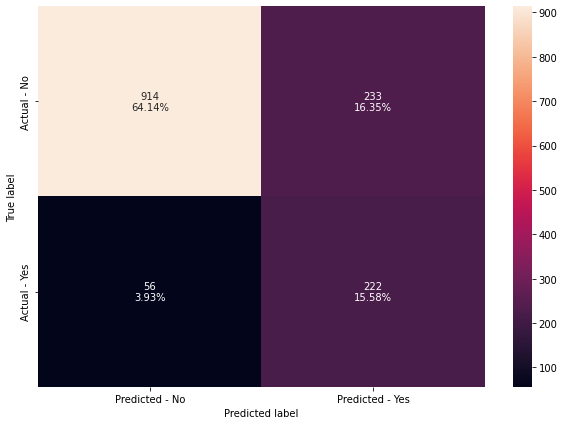

In [ ]:
make_confusion_matrix(xgb_tuned,y_test)

**Interpretation:** This model is for sure the best among all the previous models created in this project. Although there is some potential overfitting issue (the recall score on training set is 0.08 higher than the recall on testing set), the recall score in both testing and training sets is very high, and the percentage of false negative is very low (3.93%) compared to previous models.

Also, I should note that I had to limit the parameters and the values used for hypertuning XGBoost; otherwise, it was taking too much time. It means that if I had more time and maybe a faster computer, I could select more parameters and parameter values, which could have made the model even better.

##Stacking Classifier##

Now, I will create a model by stacking the tuned models which are bagging, random forest, and gradient boosting. Then, I will use XGBoost to get the final prediction.

In [ ]:
estimators=[('Bagging', bagging_estimator_tuned),('Random Forest', rf_estimator_tuned),
           ('Gradient Boosting', gbc_tuned)]
final_estimator=XGBClassifier(random_state=1)

In [ ]:
stacking_estimator=StackingClassifier(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

StackingClassifier(cv=5,
                   estimators=[('Bagging',
                                BaggingClassifier(max_features=0.9,
                                                  max_samples=0.9,
                                                  n_estimators=60,
                                                  random_state=1)),
                               ('Random Forest',
                                RandomForestClassifier(max_features=0.6,
                                                       max_samples=0.6,
                                                       min_samples_leaf=5,
                                                       n_estimators=150,
                                                       random_state=1)),
                               ('Gradient Boosting',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                           max_features=0.9,
                 

In [ ]:
stacking_metrics=get_metrics_score(stacking_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.9312280701754386
Recall on training set :  1.0
Recall on test set :  0.7338129496402878
Precision on training set :  1.0
Precision on test set :  0.8947368421052632


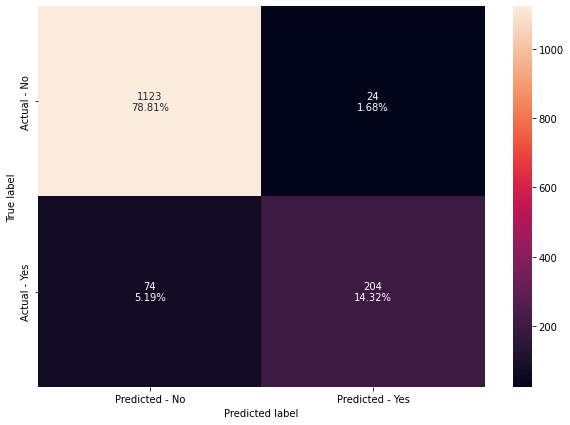

In [ ]:
make_confusion_matrix(stacking_estimator,y_test)

**Interpretation:** The XGBoost tuned model is still better than the stacking model. Although recall on training is 1, the difference between that and recall on test set is large (27%), whereas it was only 8 percent in XGBoost tuned model.

##Comparing the models: Part 2

In [ ]:
models = [abc, abc_tuned, gbc, gbc_tuned, xgb, xgb_tuned]

acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [ ]:
comparison_frame_2 = pd.DataFrame({'Model':['AdaBoost-Default','AdaBoost-Tuned', 
                                          'Gradient Boosting - Default',
                                          'Gradient Boosting Tuned','XGBoost - Default','XGBoost Tuned'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame_2

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,AdaBoost-Default,0.86,0.84,0.35,0.32,0.76,0.68
1,AdaBoost-Tuned,0.98,0.87,0.93,0.57,0.97,0.70
2,Gradient Boosting - Default,0.89,0.85,0.49,0.35,0.88,0.76
3,Gradient Boosting Tuned,0.91,0.87,0.59,0.44,0.91,0.79
4,XGBoost - Default,0.89,0.85,0.45,0.33,0.87,0.77
5,XGBoost Tuned,0.84,0.80,0.88,0.80,0.54,0.49


**Final Decision:** The winner is definitely XGBoost Tuned. It has way lower overfitting issue and significantly higher recall score. Although AdaBoost-Default and Stacking models have higher recall score on training set, their recall score on testing set is low compared to XGBoost Tuned and there are more overfitting issues in them.

##Feature Importance##

Now that we decided on the winner model, we can look at which features are more important based on that model.


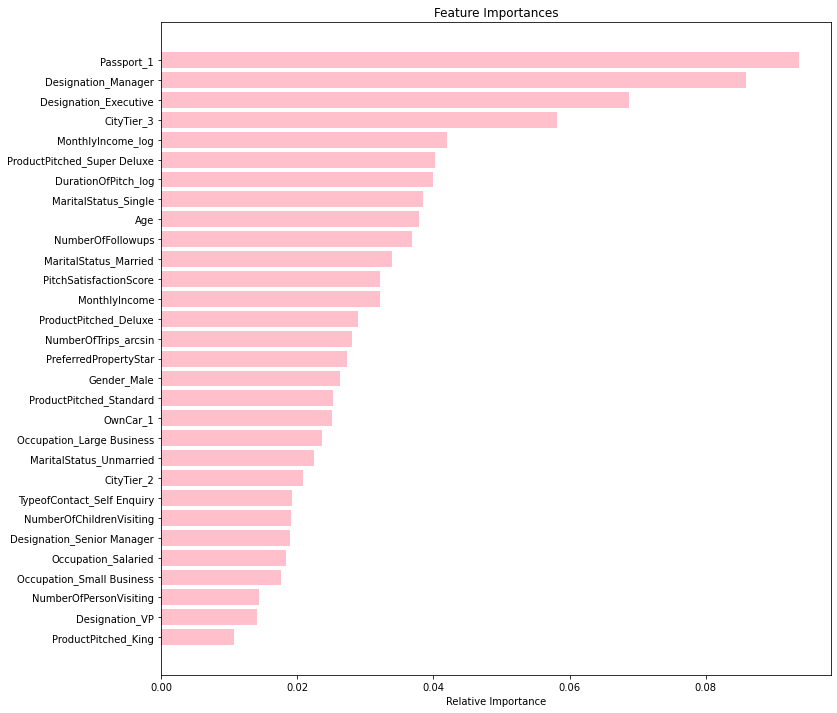

In [ ]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='pink', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Interpretation:** We see that passport, designation, living in the city tier 3, and monthly income are important independent variables or predictors that should be taken into account.

#Business Insights#

1) As one's monthly income increases, the package he or she purchases tends to be more expensive package. For example, those who purchased King package had higher monthly income on average compared to other who purchased Basic package.Therefore, the company should first determine which one of the five packages is similar to the new Wellness Tourism Package in terms of price. For example, if the price of Wellness Tourism Package is close to Standard Package, then they should target the monthly income corresponding to that package. 

2) More people purchased the affordable packages like Basic or Deluxe, whereas less people purchased more luxurious packages on average. Therefore, if the company wants to sell the new package in large quantities, then its price should be similar to Basic or Deluxe. If they prefer to sell the package to a specialized segment of the market rather than aiming for large quantities, then its price can be higher. 

3) People with no passport were found to more likely purchase one of the five packages compared to people with passport. It may be because that people with passport prefer to visit foreign countries. Therefore, if the company decides to expand their operation to foreign travel, then they can find more people to sell their new package. Otherwise, they should target people with no passport. 

4) Men were found to more likely purchase one of the five packages. However, considering that women are more interested in wellness and health, the new Wellness Tourism package may attract them. A related finding was that there was no gender difference in Super Deluxe Package. The company may find what makes Super Deluxe different than other packages and include those things into their new package to make it attractive for both genders.